# Random Forest 

We will use the cleaned articles from the Technology section of Medium. https://medium.com/topic/technology


In [1]:
#import some stuff

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, confusion_matrix

import math
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime


/Users/catherine/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/catherine/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/catherine/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import time
import os
import ast
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np

import itertools
import re
from langdetect import detect


import nltk
from nltk.corpus import stopwords

/Users/catherine/.pyenv/versions/3.6.5/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
#Read them in 
df = pd.read_csv("medium_TECH_articles_clean.csv") #, index_col=0)
df.tail()

,author,author_name,body,bullets,claps,date,datePublished,followedBy,following,images,interests,read_time,tags,title,url,#clean_words,#all_words
2867,Watts Martin,Watts Martin,Arguments about the tablet s certain triumph o...,[],19.0,2018-06-05 02:19,2017-03-13,437,131,"[<img class=""graf-image"" data-action=""zoom"" da...","A web developer turned technical writer, sf/fa...",7,"['Apple', 'iPad Pro', 'Tech', 'Future']","The PC isn t the future of computing, but neit...",https://hackernoon.com/dont-think-of-the-futur...,736.0,1427.0
2868,Josh Barkin,Lessons learned from experiment #1,Facebook has been in an R&D phase for the last...,['Usage: Brands that see conversions and repea...,57.0,2018-06-05 02:19,2017-03-22,345,182,"[<img class=""graf-image"" data-height=""595"" dat...",Co-Founder @ Janis / Product Designer,9,"['Chatbots', 'Bots', 'Facebook', 'Messaging', ...",How this one Facebook experiment could foresha...,https://chatbotsmagazine.com/how-this-one-face...,1097.0,1958.0
2869,Christiana Wyly,Christiana Wyly,And it s not techno-fantasy. The solutions are...,[],52.0,2018-06-05 02:19,2017-03-15,531,394,"[<img class=""graf-image"" data-action=""zoom"" da...",curates and catalyzes conversations on the fut...,7,"['Food', 'Agriculture', 'Near Future Summit', ...",The Giant Leap Our Food System Must Make,https://worldpositive.com/the-giant-leap-our-f...,888.0,1529.0
2870,Ted Power,Ted Power,Most smart appliances on the market today ar...,[],10.0,2018-06-05 02:19,2017-03-16,671,157,"[<img class=""graf-image"" data-height=""1144"" da...","Co-founder at Abacus. Also, fun guy.",5,"['Internet of Things', 'Computer Vision', 'Sma...",Will the Next Alexa Have a Camera?,https://medium.com/@tedp/will-the-next-alexa-h...,637.0,1125.0
2871,Brendan Bilko,About no,It s a hot April afternoon in Flushing. After ...,['Product makers are too reliant on tech that ...,15.0,2018-06-05 02:19,2017-03-24,136,162,"[<img class=""graf-image"" data-action=""zoom"" da...",Makes stuff. Likes watching tape measure taters.,7,"['Messaging', 'Bots', 'Conversational UI', 'Us...",The User Experience of No,https://chatbotslife.com/the-user-experience-o...,800.0,1555.0


In [4]:
df.shape

(2872, 17)

In [5]:
#Drop the duplicates based on the url
df.drop_duplicates(subset=['url'], keep='first', inplace = True)
df.reset_index(drop=True, inplace = True)

In [6]:
df.shape

(2872, 17)

In [7]:
#Edit datetime
df['datePublished'] = df['datePublished'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
df["tags"] = df["tags"].apply( lambda x:  list() if (len(x) == 1) else ast.literal_eval(x))


In [8]:
#Take a look at our data
df.dtypes

author                   object
author_name              object
body                     object
bullets                  object
claps                   float64
date                     object
datePublished    datetime64[ns]
followedBy                int64
following                 int64
images                   object
interests                object
read_time                 int64
tags                     object
title                    object
url                      object
#clean_words            float64
#all_words              float64
dtype: object

In [9]:
# 1- Extract a list of unique values from the tags column
tags_iter = (set(p) for p in df.tags)
tags = sorted(set.union(*tags_iter))
len(tags)

2119

In [10]:
# 2- Create a dummy dataset and initialize it with zeros
dummies = pd.DataFrame(np.zeros((len(df), len(tags)), dtype=np.int), columns=tags)
dummies.head()

,18f,2016 Election,2017,2018,2fa,360,360 Video,3D Printing,3d,3d Design,...,iOS 11,iOS App Development,iOS Apps,iPad,iPad Pro,iPhone,iPhone 8,iPhone Apps,iPhone Case,iTunes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# 3- iterate through the original dataframe and set entries in each row of the dummy to 1
for i, tag in enumerate(df.tags):
    dummies.loc[i, tag] = 1
    if i== 9:
        print(df.loc[i,'tags'])
        print(tag)
dummies.head()

['Artificial Intelligence', 'Machine Learning', 'Labor', 'Work', 'Recruiting']
['Artificial Intelligence', 'Machine Learning', 'Labor', 'Work', 'Recruiting']


,18f,2016 Election,2017,2018,2fa,360,360 Video,3D Printing,3d,3d Design,...,iOS 11,iOS App Development,iOS Apps,iPad,iPad Pro,iPhone,iPhone 8,iPhone Apps,iPhone Case,iTunes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#Top tags 
Top_tags = pd.DataFrame(dummies.sum().sort_values(ascending =False))
Top_tags.reset_index(inplace = True)
Top_tags.columns = ['tag_name', 'freq']
Top_tags.head(10)


,tag_name,freq
0,Technology,1106
1,Tech,591
2,Artificial Intelligence,344
3,Apple,281
4,Virtual Reality,244
5,Self Driving Cars,195
6,Business,195
7,Startup,194
8,Future,166
9,Google,165


In [13]:
Very_top_tags = Top_tags['tag_name'][Top_tags.freq >100].tolist()
Very_top_tags

['Technology',
 'Tech',
 'Artificial Intelligence',
 'Apple',
 'Virtual Reality',
 'Self Driving Cars',
 'Business',
 'Startup',
 'Future',
 'Google',
 'Design',
 'Augmented Reality',
 'Social Media',
 'Machine Learning',
 'Privacy',
 'Facebook',
 'Internet of Things',
 'Innovation',
 'Internet',
 'Blockchain']

In [14]:
#Create some more features and normalize the existing ones

sid = SentimentIntensityAnalyzer()

for tag in Very_top_tags:
    df[tag] = False
    
for i in range(df.shape[0]): 
    df.loc[i, "claps"]  = float(df.loc[i, "claps"])
    df.loc[i, "#title_words"] = int(len(df.loc[i, "title"].split()))
    df.loc[i, "#days_passed"] = ((datetime.strptime(df.loc[0,'date'], "%Y-%m-%d %I:%M") - df.loc[i,'datePublished'] ).days )
    df.loc[i, "#time_passed"] = ((datetime.strptime(df.loc[0,'date'], "%Y-%m-%d %I:%M") - df.loc[i,'datePublished'] ).days ) 
    df.loc[i, "#weeks_passed"] = ((datetime.strptime(df.loc[0,'date'], "%Y-%m-%d %I:%M") - df.loc[i,'datePublished'] ).days ) // 7
    df.loc[i, "#images"] = (df.loc[i, "images"]).count('<img')
    df.loc[i, "#tags"] = len(df.loc[i, "tags"])
#    df.loc[i, "tone_of_speech"] = (len(re.findall("[Yy]ou|[mM]e|[Mm]y|[Ww]e|I |[Hh]e|[Ss]he|[Oo]ur|[Yy]our|[Hh]im|[Hh]er|[Uu]s|[Tt]hem|[Mm]ine|[Yy]ours|[Hh]ers|[Hh]is|[Tt]heir|[Mm]yself|[Yy]ourself|[Hh]imself|[Hh]erself|[Oo]urselves|[Yy]ourselves|[Tt]hemselves|[Mm]ine|[Tt]heirs", df.loc[i, "body"])) / (df.loc[i, "#all_words"] - df.loc[i, "#clean_words"]) * 100 
    df.loc[i, "tone_of_speech"] = (len(re.findall("[Yy]ou|[mM]e|[Mm]y[Ww]e|I |[Oo]ur|[Yy]our|[Oo]urs|[Yy]ours|[Mm]ine", df.loc[i, "body"]))  /
                             (df.loc[i, "#all_words"] - df.loc[i, "#clean_words"])) * 100 
    df.loc[i, "keyword_proportion"] = (df.loc[i, "#clean_words"] / df.loc[i, "#all_words"] ) * 100 
    df.loc[i, "title_emot_quotient"] = abs(sid.polarity_scores(df.loc[i, "title"])['compound'])
    for tag in Very_top_tags:
        df.loc[i, tag] = bool(tag in df.loc[i,"tags"]) 

    
df["followed_By"] = df["followedBy"] // 1000
df["img/word"] = df['#images']/df['#clean_words']
df['claps_per_week'] = df['claps'] // df['#weeks_passed']
df['#all_words100'] = round(df['#all_words']// 100) 



In [15]:
#Searching for previews (the articles that are not free and you can read only the first 3 lines )
#Get rid of them

shortdf = df[df['#all_words'] < 100]
df = df[df['#all_words'] >= 100]
df.reset_index(drop=True, inplace = True)

In [16]:
print(shortdf.shape, df.shape)

(571, 50) (2301, 50)


In [17]:
shortdf.loc[2635,'body']

'The dominance of Google, Facebook and Amazon is bad for consumers and competitionNot long ago, being the boss of a big Western tech firm was a dream job. As the billions rolled in, so did the plaudits: Google, Facebook, Amazon and others were making the world a better place. Today these companies are accused of being BAADD   big, anti-competitive, addictive and '

In [18]:
#It seems that the authors of these articles are news outlets and magazines
shortdf.head()

,author,author_name,body,bullets,claps,date,datePublished,followedBy,following,images,...,#weeks_passed,#images,#tags,tone_of_speech,keyword_proportion,title_emot_quotient,followed_By,img/word,claps_per_week,#all_words100
21,Rolling Stone,No Author Name,Inside the inventor s world-changing plans to ...,[],8100.0,2018-06-04 19:17,2017-11-15,82884,41,"[<img class=""graf-image"" data-external-src=""ht...",...,28.0,1.0,5.0,0.000000,68.421053,0.0000,82,0.038462,289.0,0.0
22,The Financial Times,No Author Name,"Facebook founder is a digital superstar, but h...",[],8800.0,2018-06-04 19:18,2017-11-15,16108,0,"[<img class=""graf-image"" data-focus-x=""47"" dat...",...,28.0,1.0,3.0,13.333333,50.819672,0.0000,16,0.032258,314.0,0.0
23,The New York Times,No Author Name,"Under pressure from investors, Snap is making ...",[],384.0,2018-06-04 19:18,2017-11-15,19215,1,"[<img class=""graf-image"" data-focus-x=""63"" dat...",...,28.0,1.0,5.0,25.000000,69.230769,0.3612,19,0.037037,13.0,0.0
36,Bloomberg,No Author Name,By Caroline ChenU.S. regulators approved the f...,[],76.0,2018-06-04 19:19,2017-11-14,131696,225,"[<img class=""graf-image"" data-height=""667"" dat...",...,29.0,1.0,4.0,12.500000,63.636364,0.4767,131,0.035714,2.0,0.0
44,The Financial Times,No Author Name,Bill Gates-backed start-up secures national US...,[],292.0,2018-06-04 19:20,2017-11-14,16108,0,"[<img class=""graf-image"" data-focus-x=""46"" dat...",...,29.0,1.0,3.0,0.000000,70.731707,0.0000,16,0.034483,10.0,0.0


In [19]:
df.shape

(2301, 50)

# Rarity

We have to pick the best way to calculate rarity

First way to compute rare words

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

vec2 = CountVectorizer()
matrix2 = vec2.fit_transform(df['body'])
vocab2 = vec2.get_feature_names()
wordcount_df2 = pd.DataFrame(matrix2.toarray(), columns=vocab2)



In [21]:
Top_words = pd.DataFrame(wordcount_df2.sum().sort_values(ascending =False))
Top_words.reset_index(inplace = True)
Top_words.columns = ['word', 'freq']
print(Top_words.shape[0])
Top_words.head()

69493


,word,freq
0,the,162397
1,to,100909
2,and,87035
3,of,80000
4,in,52566


In [22]:
Top_words = Top_words[(Top_words.word.str.isalpha())]
Top_words.reset_index(inplace = True)
print(Top_words.shape[0])


64860


In [23]:
RareWords = Top_words[Top_words.freq == 2]
RareWords.tail()

,index,word,freq
33816,35225,fabricating,2
33817,35227,fared,2
33818,35229,derry,2
33819,35230,redeem,2
33820,35231,amenity,2


Another Way to Compute Rare Words

In [24]:
nltk.download('words')
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

def unusual_words(text):
    text_vocab = set(w.lower() for w in text if w.isalpha())
    unusual = text_vocab - english_vocab
    return sorted(unusual)

[nltk_data] Downloading package words to /Users/catherine/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [25]:
import nltk
from nltk.stem import WordNetLemmatizer

stopword_list = nltk.corpus.stopwords.words('english')
wnl = WordNetLemmatizer()

from pattern3.en import tag, parse, suggest, lemma
from nltk.corpus import wordnet as wn
import ssl 


from nltk.corpus import wordnet as wn
# Annotate text tokens with POS tags

def pos_tag_text(text):
# convert Penn treebank tag to wordnet tag

  def penn_to_wn_tags(pos_tag):
    if pos_tag.startswith('J'):
        return wn.ADJ
    elif pos_tag.startswith('V'):
        return wn.VERB
    elif pos_tag.startswith('N'):
        return wn.NOUN
    elif pos_tag.startswith('R'):
        return wn.ADV
    else:
        return None
    
  tagged_text = tag(text)
  tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                        for word, pos_tag in
                        tagged_text]
  return tagged_lower_text
# lemmatize text based on POS tags


def lemmatize_text(text):
    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
                            else word
                            for word, pos_tag in pos_tagged_text]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text


In [26]:
UnList = [df["body"].apply(lambda x: unusual_words(nltk.word_tokenize(lemmatize_text(x))))]

In [27]:
flat_list = [item2 for sublist in UnList for item in sublist for item2 in item]

In [28]:
flat_list

['anytime',
 'businessesbusinesses',
 'chatbot',
 'chatbotalternatively',
 'chatbotfacebook',
 'chatbothow',
 'chatbots',
 'email',
 'facebook',
 'forbeswhy',
 'google',
 'ibm',
 'improvising',
 'influencing',
 'interactionsowning',
 'internet',
 'ipad',
 'iphone',
 'isn',
 'landhave',
 'macfacebook',
 'macgoogle',
 'messaging',
 'ml',
 'nlp',
 'online',
 'planning',
 'processing',
 'quenching',
 'siri',
 'smartphone',
 'smbs',
 'startup',
 'thenextwebchatbots',
 'viralcredit',
 'wonderingif',
 'aforementioned',
 'anymore',
 'aws',
 'benklerfred',
 'centralized',
 'cockroft',
 'contracting',
 'coordination',
 'decentralized',
 'earlier',
 'erp',
 'expertise',
 'http',
 'https',
 'internet',
 'mainstream',
 'ml',
 'netsneural',
 'nielsen',
 'others',
 'planning',
 'processing',
 'redefines',
 'storyline',
 'workin',
 'yochai',
 'agi',
 'aren',
 'arguably',
 'bitcoin',
 'coinmotion',
 'couldn',
 'crowdsourced',
 'davidthere',
 'doesn',
 'download',
 'entrepeneur',
 'google',
 'hellfire',

In [29]:
len(flat_list)

85250

A third way to compute Rare Words that uses nltk.corpus.words.words()

In [30]:
from wordfreq import zipf_frequency
from wordfreq import top_n_list
from wordfreq import get_frequency_dict
from langdetect import detect

In [31]:
def is_ascii(s):
    return all(ord(c) < 128 for c in s)

In [32]:
rare_dic = get_frequency_dict('en', wordlist='best')


In [33]:
rare_df = pd.DataFrame(list(rare_dic.items()), columns=['word', 'freq'])

In [34]:
rare_list = rare_df[rare_df['freq']< 0.5* rare_df['freq'].mean()]['word'].tolist()

In [35]:
rare_list_clean = [ y for y in rare_list if (str.isalpha(y)  & is_ascii(y) & (y in english_vocab))]

In [36]:
len(rare_list_clean)

49658

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
#CountVectorizer(stop_words='english', binary=True)
# I only want you to look for words in the emotional lexicon
# because we don't know what's up with the other words
vec3 = TfidfVectorizer(vocabulary= rare_list_clean, #RareWords.word,
                      use_idf=False, 
                      norm= None ) #'l1') # ELL - ONE
matrix3 = vec3.fit_transform(df['body'])
vocab3 = vec3.get_feature_names()
wordcount_df3 = pd.DataFrame(matrix3.toarray(), columns=vocab3)
wordcount_df3.head()

,aides,amplitude,angled,anon,apiece,archival,arming,assertive,astray,astronomer,...,victualing,vindhyan,vivify,voguish,vulcanism,whittler,yoruban,yote,zanthoxylum,zieger
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
df['Beautiful_phrasing'] = (wordcount_df3[rare_list_clean].sum(axis=1)  / df['#clean_words']) *100

In [39]:
df[df.Beautiful_phrasing != 0]['Beautiful_phrasing'].sort_values(ascending = False).head()

1684    9.896433
1790    9.584665
230     8.244111
1021    7.795699
316     7.611549
Name: Beautiful_phrasing, dtype: float64

In [41]:
filepath = "Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emolex_df = emolex_df.pivot(index='word', columns='emotion', values='association').reset_index()
emolex_df.head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,NaN,0,0,0,0,0,0,0,0,0,0
1,aback,0,0,0,0,0,0,0,0,0,0
2,abacus,0,0,0,0,0,0,0,0,0,1
3,abandon,0,0,0,1,0,1,0,1,0,0
4,abandoned,1,0,0,1,0,1,0,1,0,0


Examples

In [42]:
pos_tag_text("We went to school")

[('we', None), ('went', 'v'), ('to', None), ('school', 'n')]

In [43]:
lemmatize_text("I went to school")

'i go to school'

In [44]:

df['lemma_content'] = df['body'].apply(lambda x:lemmatize_text(x))


In [45]:
from pattern3.en import tokenize,Text, sentiment

tokenize("I've this is one. This is two. And three!", punctuation=".,;:!?()[]{}`''\"@#$^&*+-|=~_",  replace={"'ve": " 've"})
#tokenize('this is one. This is two! And three!')


["I 've this is one .", 'This is two .', 'And three !']

In [46]:
sas = nltk.Text(df.loc[0,'body']) #.nltk.Text(split(' ')).dispersion_plot(["sense", "love", "heart", "listen", "man", "woman"])

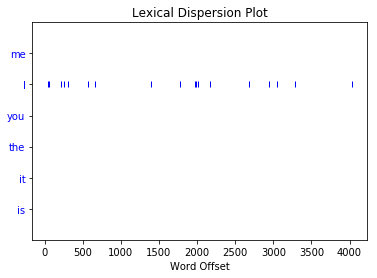

In [47]:
sas.dispersion_plot(["me", "I", "you", "the", "it", "is"])

In [48]:
text = df['body'].str.cat(sep=' ')

In [49]:
text = text.replace('.', ' ').replace('-', ' ').replace(':', ' ')

In [50]:
text_list = text.split()

In [51]:
longWords = [w for w in set(text_list) if ( (len(w) > 13) & w.isalpha() & (w in english_vocab))]
longWords[:15]

['newsworthiness',
 'quantitatively',
 'misinformation',
 'organizational',
 'enforceability',
 'sociopolitical',
 'unidirectional',
 'collaboratively',
 'frictionlessly',
 'disinterestedness',
 'neurodegenerative',
 'instrumentally',
 'deliberatively',
 'counterargument',
 'reinterpretation']

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
#CountVectorizer(stop_words='english', binary=True)
# I only want you to look for words in the emotional lexicon
# because we don't know what's up with the other words
vec = TfidfVectorizer(vocabulary=emolex_df.word,
                      use_idf=False, 
                      norm= None ) #'l1') # ELL - ONE
matrix = vec.fit_transform(df['lemma_content'])
vocab = vec.get_feature_names()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wordcount_df.head()

,nan,aback,abacus,abandon,abandoned,abandonment,abate,abatement,abba,abbot,...,zephyr,zeppelin,zest,zip,zodiac,zone,zoo,zoological,zoology,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
emolex_df.head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,NaN,0,0,0,0,0,0,0,0,0,0
1,aback,0,0,0,0,0,0,0,0,0,0
2,abacus,0,0,0,0,0,0,0,0,0,1
3,abandon,0,0,0,1,0,1,0,1,0,0
4,abandoned,1,0,0,1,0,1,0,1,0,0


In [54]:
emolex_df[emolex_df.anger == 1].head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
4,abandoned,1,0,0,1,0,1,0,1,0,0
5,abandonment,1,0,0,1,0,1,0,1,1,0
18,abhor,1,0,1,1,0,1,0,0,0,0
19,abhorrent,1,0,1,1,0,1,0,0,0,0
28,abolish,1,0,0,0,0,1,0,0,0,0


In [55]:
# Get your list of positive words

angry_words = emolex_df[emolex_df.anger == 1]['word']

positive_words = emolex_df[emolex_df.positive == 1]['word']


# Get your list of sadness words
sadness_words = emolex_df[emolex_df.sadness == 1]['word']


# Get your list of surprise words
surprise_words = emolex_df[emolex_df.surprise == 1]['word']


# Get your list of disgust words
disgust_words = emolex_df[emolex_df.disgust == 1]['word']


# Get your list of anticipation words
anticipation_words = emolex_df[emolex_df.anticipation == 1]['word']


# Get your list of negative words
negative_words = emolex_df[emolex_df.negative == 1]['word']



# Get your list of joy words
joy_words = emolex_df[emolex_df.joy == 1]['word']


# Get your list of trust words
trust_words = emolex_df[emolex_df.trust == 1]['word']



# Get your list of fear words
fear_words = emolex_df[emolex_df.fear == 1]['word']




In [56]:
df['anger'] = (wordcount_df[angry_words].sum(axis=1) / df['#clean_words']) *100

df['positivity'] = (wordcount_df[positive_words].sum(axis=1) / df['#clean_words']) *100


df['joy'] = (wordcount_df[joy_words].sum(axis=1) / df['#clean_words']) *100


df['disgust'] = (wordcount_df[disgust_words].sum(axis=1) / df['#clean_words']) *100



df['surprise'] = (wordcount_df[surprise_words].sum(axis=1) / df['#clean_words']) *100

df['trust'] = (wordcount_df[trust_words].sum(axis=1) / df['#clean_words']) *100


df['anticipation'] = (wordcount_df[anticipation_words].sum(axis=1) / df['#clean_words']) *100


df['sadness'] = (wordcount_df[sadness_words].sum(axis=1) / df['#clean_words']) *100

df['negative'] = (wordcount_df[negative_words].sum(axis=1) / df['#clean_words']) *100

df['fear'] = (wordcount_df[fear_words].sum(axis=1) / df['#clean_words']) *100

df['density'] = df['positivity'] + df['negative']

df['joysad'] = np.where(df['joy']> df['sadness'], 1, 0)






In [57]:
df['density'].head(5)

0    20.758929
1    18.003565
2    19.776119
3    17.372881
4    15.327381
Name: density, dtype: float64

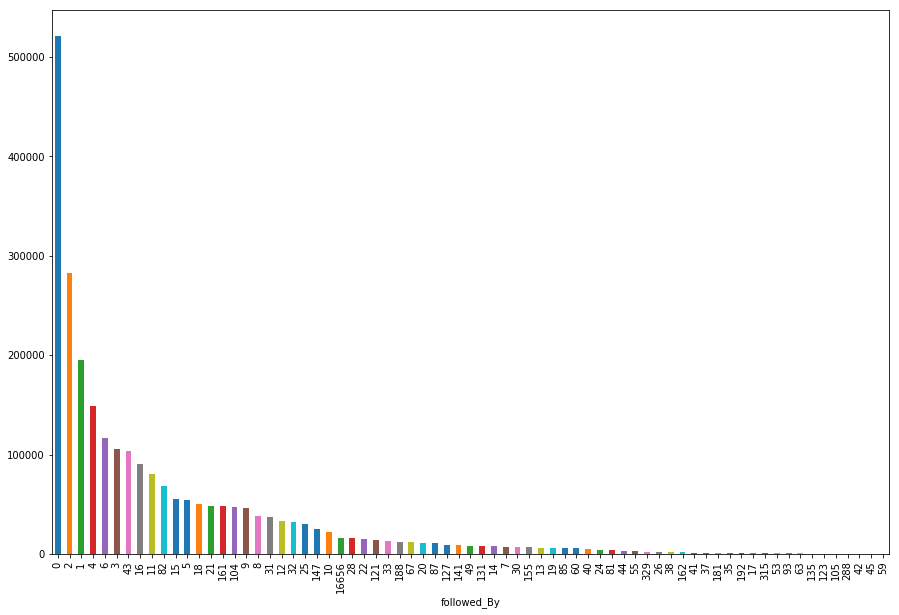

In [58]:
df.groupby('followed_By')['claps'].sum().sort_values(ascending = False).plot(kind='bar', figsize=(15,10))

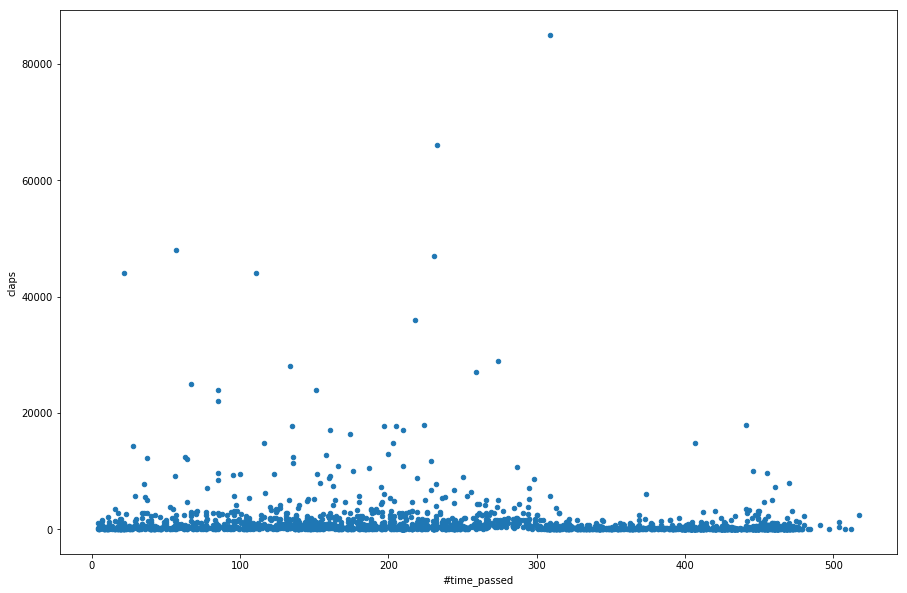

In [59]:
df[(df['#time_passed'] < 520)].plot(x='#time_passed', y='claps', kind='scatter', figsize=(15,10))

In [60]:
df[(df.Google)  & (df.claps < 65000)].shape

(111, 64)

Bucket by proportion

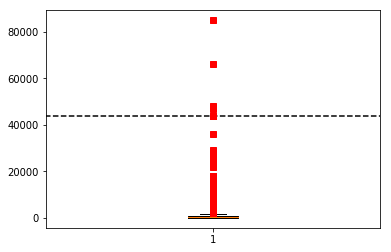

In [61]:
#claps = pd.Series(df[df.Politics]['claps'])
claps = pd.Series(df[(df["#days_passed"] < 520) & (df["#days_passed"] > 20)]['claps'])
#claps = pd.Series(df['claps_per_week'])
plt.boxplot(claps.values,0,'rs')
plt.hlines(y = claps.quantile(0.998), label = '99.8 percentile', xmin = 0,xmax = 100, linestyles='dashed' )


In [62]:
data = pd.DataFrame()

quant_998 = claps.quantile([0.998])
print(quant_998)
#data = df[(df.followedBy1000 <= 1) &  (df["claps"] < int(quant_995))].copy()
#data = df[(df.Politics) &  (df["claps"] < int(quant_995))].copy()
data = df[ (df["claps"] < int(quant_998)) & (df["#days_passed"] < 520) & (df["#days_passed"] > 20)].copy()
data.reset_index(drop=True, inplace = True)
data.shape

0.998    44000.0
Name: claps, dtype: float64


(2193, 64)

In [63]:
data.tail(2)

,author,author_name,body,bullets,claps,date,datePublished,followedBy,following,images,...,joy,disgust,surprise,trust,anticipation,sadness,negative,fear,density,joysad
2191,Ted Power,Ted Power,Most smart appliances on the market today ar...,[],10.0,2018-06-05 02:19,2017-03-16,671,157,"[<img class=""graf-image"" data-height=""1144"" da...",...,2.040816,0.784929,0.470958,5.33752,3.296703,1.098901,2.825746,2.040816,13.186813,1
2192,Brendan Bilko,About no,It s a hot April afternoon in Flushing. After ...,['Product makers are too reliant on tech that ...,15.0,2018-06-05 02:19,2017-03-24,136,162,"[<img class=""graf-image"" data-action=""zoom"" da...",...,3.375000,1.625000,1.750000,4.87500,5.750000,1.625000,4.125000,2.125000,16.750000,1


In [64]:
int(quant_998)

44000

In [65]:
claps=pd.Series(data['claps'])
n_buckets = 2
buckets, bins = pd.qcut(claps, n_buckets, labels=False, retbins=True, precision=2) 
#buckets, bins = pd.cut(claps, [0,100,1500,50000], labels=False, include_lowest = True, retbins=True, precision=2) 

bins = pd.Series(bins).apply(lambda x: format(x, 'f'))
bin_data = pd.DataFrame([(buckets.sort_values(ascending=True)).unique(), bins[0:len(bins)-1], bins[1:len(bins)]]).transpose()
bin_data.columns = ['bucket', 'start', 'end']
bin_data.astype('f')

,bucket,start,end
0,0.0,0.0,215.0
1,1.0,215.0,36000.0


In [66]:
bins

0        0.000000
1      215.000000
2    36000.000000
dtype: object

In [67]:
buckets.tail(5)

2188    0
2189    0
2190    0
2191    0
2192    0
Name: claps, dtype: int64

In [68]:
data['new_claps'] = buckets
#data['new_claps'] = data.claps.rank(method='dense').astype(int)
data.head()

,author,author_name,body,bullets,claps,date,datePublished,followedBy,following,images,...,disgust,surprise,trust,anticipation,sadness,negative,fear,density,joysad,new_claps
0,Ms.Mausam,What Are Chatbots?,The Story of Chatbots (using Artificial Intell...,['An efficient and well-designed chatbot impar...,11.0,2018-06-05 01:40,2017-04-17,68,99,"[<img class=""graf-image"" data-height=""1080"" da...",...,0.446429,3.348214,13.169643,5.803571,0.446429,2.232143,2.901786,20.758929,1,0
1,Esko Kilpi,Esko Kilpi,From Michael Nielsen s book on neural netsNeur...,[],126.0,2018-06-05 01:40,2017-04-16,5191,1243,"[<img class=""graf-image"" data-action=""zoom"" da...",...,0.356506,2.139037,12.477718,8.912656,1.604278,2.139037,2.673797,18.003565,1,0
2,Teemu Paivinen,Teemu Paivinen,A painting of Socrates by Jacques-Louis DavidT...,[],92.0,2018-06-05 01:40,2017-04-17,852,83,"[<img class=""graf-image"" data-action=""zoom"" da...",...,0.746269,0.746269,6.529851,5.410448,1.679104,3.171642,2.798507,19.776119,1,0
3,Proekspert,Proekspert,How anthropological methods can answer tough q...,[],8.0,2018-06-05 01:41,2017-04-11,27,12,"[<img class=""graf-image"" data-action=""zoom"" da...",...,0.000000,2.118644,5.720339,4.661017,1.271186,3.177966,2.966102,17.372881,1,0
4,Taylor Lorenz,Taylor Lorenz,"Last week, Facebook announced that Instagram S...",[],1100.0,2018-06-05 01:41,2017-04-17,4115,1639,"[<img class=""graf-image"" data-height=""429"" dat...",...,0.595238,1.041667,6.845238,4.910714,1.636905,3.422619,1.488095,15.327381,1,1


## Adding more features

### Text sentiment

### Day of week

In [69]:

data['day'] = data['datePublished'].dt.day

data['day_of_week'] = data['datePublished'].dt.dayofweek

data['month'] = data['datePublished'].dt.month

data['is_month_end'] = data['datePublished'].dt.is_month_end

data['is_quarter_end'] = data['datePublished'].dt.is_quarter_end

data['is_month_start'] = data['datePublished'].dt.is_month_start

data['is_quarter_start'] = data['datePublished'].dt.is_quarter_start

data['week_of_year'] = data['datePublished'].dt.weekofyear

data['quarter'] = data['datePublished'].dt.quarter



data['bullets_present'] = data['bullets'].apply(lambda x: 0 if len(x) == 1 else 1)

data['#links'] = data['url'].apply(lambda x: len(x.split(',')))



In [70]:
data.shape

(2193, 76)

In [71]:
data.columns

Index(['author', 'author_name', 'body', 'bullets', 'claps', 'date',
       'datePublished', 'followedBy', 'following', 'images', 'interests',
       'read_time', 'tags', 'title', 'url', '#clean_words', '#all_words',
       'Technology', 'Tech', 'Artificial Intelligence', 'Apple',
       'Virtual Reality', 'Self Driving Cars', 'Business', 'Startup', 'Future',
       'Google', 'Design', 'Augmented Reality', 'Social Media',
       'Machine Learning', 'Privacy', 'Facebook', 'Internet of Things',
       'Innovation', 'Internet', 'Blockchain', '#title_words', '#days_passed',
       '#time_passed', '#weeks_passed', '#images', '#tags', 'tone_of_speech',
       'keyword_proportion', 'title_emot_quotient', 'followed_By', 'img/word',
       'claps_per_week', '#all_words100', 'Beautiful_phrasing',
       'lemma_content', 'anger', 'positivity', 'joy', 'disgust', 'surprise',
       'trust', 'anticipation', 'sadness', 'negative', 'fear', 'density',
       'joysad', 'new_claps', 'day', 'day_of_week', 

In [72]:
# data.head()

In [73]:
features = [
     'anger', 'positivity', 'joy', 'disgust',  'surprise', 'trust', 'density', 'read_time', 
            'Beautiful_phrasing', 
            'anticipation', 'sadness', 'negative', 'fear',  '#title_words', '#all_words100', # 'rare', #'#days_passed', 
             '#images',  '#tags', '#clean_words', #'#all_words', 'tone_of_speech2', 
         'tone_of_speech',  'followed_By',   'following', 'bullets_present', # '#time_passed',
        'img/word',  'keyword_proportion', #'day', 'day_of_week', #'month', 
        #'followedBy',  #'read_time',  
            '#links', # '#weeks_passed',
    'Technology', 
       'Artificial Intelligence', 'Apple', 'Virtual Reality',
       'Self Driving Cars', 'Business', 'Startup', 'Future', 'Google',
       'Design', 'Augmented Reality', 'Social Media', 'Machine Learning',
       'Privacy', 'Facebook', 'Internet of Things', 'Innovation', 'Internet',
       'Blockchain'

]  # 'is_month_end', 'is_quarter_end', 
          #  'is_month_start', 'is_quarter_start',
      # 'week_of_year', 'quarter']

In [74]:
#data.dropna(inplace=True)

In [75]:
X = data[features]
y = data['new_claps']

In [76]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=10)

In [77]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1754, 44), (439, 44), (1754,), (439,))

In [78]:
rf = RandomForestClassifier()

In [79]:
rf = RandomForestClassifier()
grid = {'min_samples_leaf' : [ 5, 10, 20, 40], 'max_features' : ['auto', 'log2', 'sqrt'], 'min_samples_split' : [5, 15, 25]
       }
clf = GridSearchCV(rf, grid, cv=5)
clf.fit(X_train, y_train)
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [80]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=22, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=28, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

rf.fit(X_train, y_train)
val_pred_probs = rf.predict_proba(X_val)

val_pred = rf.predict(X_val)

In [81]:
train_pred_probs = rf.predict_proba(X_train)
train_pred = rf.predict(X_train)

#train_pred

In [82]:
log_loss(y_val, val_pred_probs, labels=rf.classes_)

0.6496145287581717

In [83]:
log_loss(y_train, train_pred_probs, labels=rf.classes_)

0.5778954142338019

In [84]:
# pd.Series(val_pred).value_counts()

In [85]:
fi = pd.DataFrame(rf.feature_importances_, X_train.columns)
fi.columns = ['Importance']
fi.sort_values(by = 'Importance', ascending=False)[0:20]

,Importance
followed_By,0.095101
#clean_words,0.076497
keyword_proportion,0.059701
positivity,0.053838
density,0.050951
disgust,0.048219
negative,0.047797
trust,0.046101
Beautiful_phrasing,0.045030
#all_words100,0.043154


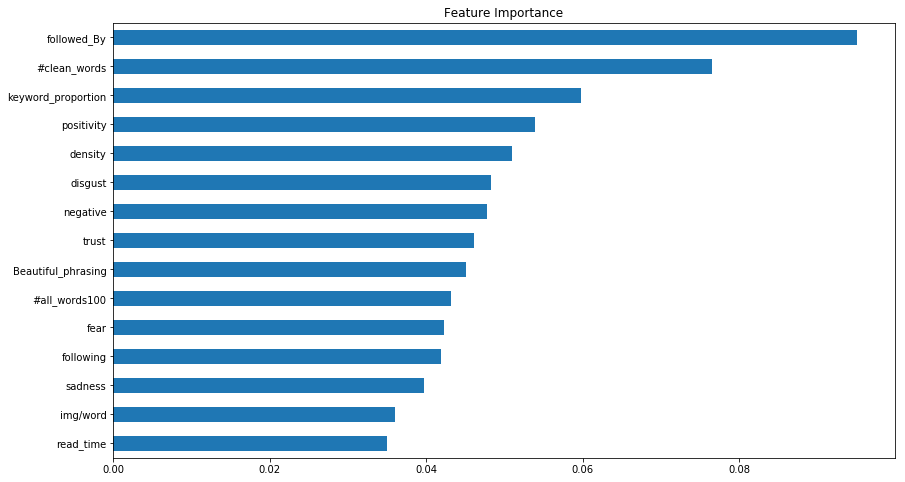

In [86]:
import matplotlib.pyplot as plt

plot = fi.sort_values(by = 'Importance', ascending=True).tail(15).plot.barh(figsize = (14,8), legend = False, title = 'Feature Importance')
fig = plot.get_figure()
fig.savefig('importance.png')


In [87]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Automatically created module for IPython interactive environment


Confusion matrix, without normalization
[[154  58]
 [ 99 128]]


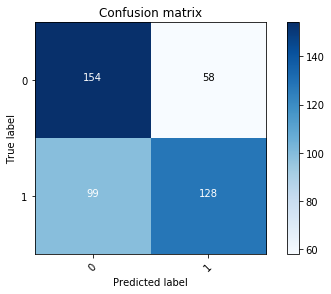

In [88]:
# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_train, train_pred)

cnf_matrix = confusion_matrix(y_val, val_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=rf.classes_,
                      title='Confusion matrix')


In [89]:
f1_score(y_val, val_pred, average='macro')

0.6411101564737431

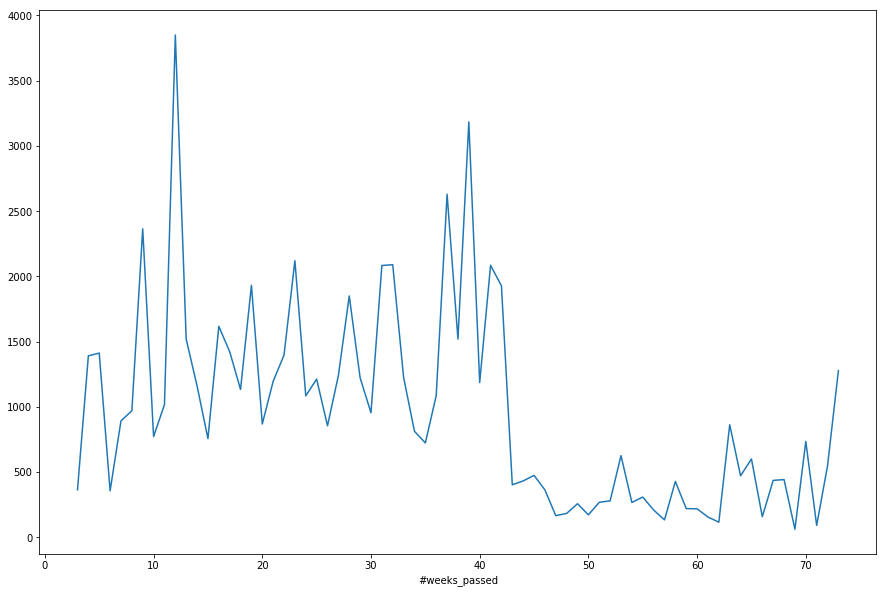

In [90]:
data.groupby('#weeks_passed')['claps'].mean().plot(  figsize=(15,10)) #x = '#weeks_passed', y = 'new_claps', kind='line',

In [91]:
MAX_ROUNDS = 180
OPTIMIZE_ROUNDS = True
LEARNING_RATE = 0.1
EARLY_STOPPING_ROUNDS = 55  
# Note: I set EARLY_STOPPING_ROUNDS high so that (when OPTIMIZE_ROUNDS is set)
#       I will get lots of information to make my own judgment.  You should probably
#       reduce EARLY_STOPPING_ROUNDS if you want to do actual early stopping.

In [116]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
#from numba import jit
import time
import gc

In [93]:
# Compute gini

# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
#@jit
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]



In [127]:
X = data[features]
y = data['new_claps']

In [128]:
y_valid_pred = 0*y
y_test_pred = 0

In [129]:
# Set up folds
K = 5
kf = KFold(n_splits = K, random_state = 1, shuffle = True)
np.random.seed(0)

In [130]:
# Set up classifier
model = XGBClassifier(    
                        n_estimators=MAX_ROUNDS,
                        max_depth=8,
                        objective="binary:logistic",
                        learning_rate=LEARNING_RATE, 
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )

In [135]:
# Run CV


for i, (train_index, test_index) in enumerate(kf.split(data)):
    
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
#    X_test = test_df.copy()
    print( "\nFold ", i)
    
    # Run model for this fold
    if OPTIMIZE_ROUNDS:
        eval_set=[(X_valid,y_valid)]
        fit_model = model.fit( X_train, y_train, 
                               eval_set=eval_set,
                               eval_metric='mlogloss',
                               early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                               verbose=True
                             )
        print( "  Best N trees = ", model.best_ntree_limit )
        print( "  Best gini = ", model.best_score )
    else:
        fit_model = model.fit( X_train, y_train )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict_proba(X_valid)  
    print( "  LogLoss = ", log_loss(y_valid, pred) )
   # y_valid_pred.iloc[test_index] = pred  error
    
    # Accumulate test set predictions
#    y_test_pred += fit_model.predict_proba(X_test)[:,1]
    
    del X_train, X_valid, y_train
    
#y_test_pred /= K  # Average test set predictions
y_val2 = fit_model.predict_proba(X)
print( "\nGini for full training set:" )
log_loss(y, y_val2)


Fold  0
  LogLoss =  0.6919548336017648

Fold  1
  LogLoss =  0.6902808017502613

Fold  2
  LogLoss =  0.6957622906681074

Fold  3
  LogLoss =  0.6633844806315148

Fold  4
  LogLoss =  0.6545132857887712

Gini for full training set:


0.6541289869123433

In [136]:
val_pred = fit_model.predict(X_val)

/Users/catherine/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization
[[ 59 153]
 [  5 222]]


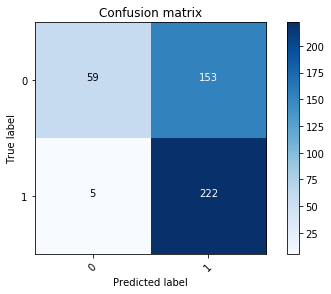

In [137]:
# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_train, train_pred)

cnf_matrix = confusion_matrix(y_val, val_pred)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=rf.classes_,
                      title='Confusion matrix')
